In [1]:
# importing libaries

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [3]:
class LEMCell(nn.Module):
    def __init__(self, ninp, nhid, dt):
        super(LEMCell, self).__init__()
        self.ninp = ninp
        self.nhid = nhid
        self.dt = dt
        self.inp2hid = nn.Linear(ninp, 4 * nhid)
        self.hid2hid = nn.Linear(nhid, 3 * nhid)
        self.transform_z = nn.Linear(nhid, nhid)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.nhid)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, y, z):
        transformed_inp = self.inp2hid(x)
        transformed_hid = self.hid2hid(y)
        i_dt1, i_dt2, i_z, i_y = transformed_inp.chunk(4, 1)
        h_dt1, h_dt2, h_y = transformed_hid.chunk(3, 1)

        ms_dt_bar = self.dt * torch.sigmoid(i_dt1 + h_dt1)
        ms_dt = self.dt * torch.sigmoid(i_dt2 + h_dt2)

        z = (1. - ms_dt) * z + ms_dt * torch.tanh(i_y + h_y)
        y = (1. - ms_dt_bar) * y + ms_dt_bar * torch.tanh(self.transform_z(z) + i_z)

        return y, z

# Define the LEM model
class LEM(nn.Module):
    def __init__(self, ninp, nhid, nout, dt=1.):
        super(LEM, self).__init__()
        self.nhid = nhid
        self.cell = LEMCell(ninp, nhid, dt)
        self.classifier = nn.Linear(nhid, nout)
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'classifier' in name and 'weight' in name:
                nn.init.kaiming_normal_(param.data)

    def forward(self, input):
        y = input.data.new(input.size(1), self.nhid).zero_()
        z = input.data.new(input.size(1), self.nhid).zero_()
        for x in input:
            y, z = self.cell(x, y, z)
        out = self.classifier(y)
        return out

In [4]:
# Toy problem data
input_size = 256  # number of columns in a dataset
hidden_size = 32  # number of neurons
output_size = 256  
sequence_length = 160  # number of sequences/ number of rows
batch_size = 1
num_epochs = 20000

In [5]:
# importing data

In [6]:
# Load the .mat file
v_data = scipy.io.loadmat('v.mat')
h_data = scipy.io.loadmat('h.mat')
x_data = scipy.io.loadmat('x.mat')
h_data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Thu Jul 20 15:02:48 2023',
 '__version__': '1.0',
 '__globals__': [],
 'h': array([[0.03949907, 0.03945555, 0.03968762, ..., 0.04081577, 0.04034067,
         0.03995187],
        [0.03949522, 0.03972834, 0.04007071, ..., 0.0406224 , 0.0405568 ,
         0.04021852],
        [0.03980837, 0.03966293, 0.04008707, ..., 0.04077249, 0.04050591,
         0.04019281],
        ...,
        [0.04915863, 0.04935256, 0.04961976, ..., 0.04917885, 0.04899574,
         0.04881741],
        [0.04904458, 0.04916197, 0.04943338, ..., 0.04902097, 0.04897786,
         0.04875013],
        [0.04913692, 0.04932824, 0.04941899, ..., 0.04888785, 0.0488357 ,
         0.04855312]])}

In [7]:
x = x_data['X']
u = h_data['h']

In [8]:
print(x.shape)
print(u.shape)
u

(201, 256)
(201, 256)


array([[0.03949907, 0.03945555, 0.03968762, ..., 0.04081577, 0.04034067,
        0.03995187],
       [0.03949522, 0.03972834, 0.04007071, ..., 0.0406224 , 0.0405568 ,
        0.04021852],
       [0.03980837, 0.03966293, 0.04008707, ..., 0.04077249, 0.04050591,
        0.04019281],
       ...,
       [0.04915863, 0.04935256, 0.04961976, ..., 0.04917885, 0.04899574,
        0.04881741],
       [0.04904458, 0.04916197, 0.04943338, ..., 0.04902097, 0.04897786,
        0.04875013],
       [0.04913692, 0.04932824, 0.04941899, ..., 0.04888785, 0.0488357 ,
        0.04855312]])

In [9]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [10]:
input_data = u[0:160,:]
target_data = u[1:161, :]

test_data = u[160:200, :]
test_target = u[161:201, :]

print("test data shape", test_data.shape)
print("test target shape", test_target.shape)

print("input data shape",input_data.shape)
print("Target data shape",target_data.shape)

test data shape (40, 256)
test target shape (40, 256)
input data shape (160, 256)
Target data shape (160, 256)


In [11]:
# Convert data to tensors
input_tensor = torch.tensor(input_data).view(batch_size, sequence_length, input_size).float()
target_tensor = torch.tensor(target_data).view(batch_size, sequence_length, output_size).float()

print("input tensor shape",input_tensor.shape)
print("Target tensor shape",target_tensor.shape)

input tensor shape torch.Size([1, 160, 256])
Target tensor shape torch.Size([1, 160, 256])


In [12]:
# Convert test data to tensors
test_tensor = torch.tensor(test_data).view(batch_size, 40, input_size).float()
test_target_tensor = torch.tensor(test_target).view(batch_size, 40, output_size).float()


In [13]:
# Create LEM instance
lem = LEM(input_size, hidden_size, output_size, dt=0.1)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lem.parameters(), lr=0.001)



# Training loop
for epoch in range(num_epochs):
    # Forward pass
    output = lem(input_tensor)
    loss = criterion(output, target_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}/{num_epochs}, Loss: {loss.item():.6f}')




/data/localhome/tkapoor/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 160, 256])) that is different to the input size (torch.Size([160, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 10/20000, Loss: 0.688335
Epoch: 20/20000, Loss: 0.644207
Epoch: 30/20000, Loss: 0.603241
Epoch: 40/20000, Loss: 0.560971
Epoch: 50/20000, Loss: 0.518000
Epoch: 60/20000, Loss: 0.479887
Epoch: 70/20000, Loss: 0.447305
Epoch: 80/20000, Loss: 0.418399
Epoch: 90/20000, Loss: 0.392489
Epoch: 100/20000, Loss: 0.369106
Epoch: 110/20000, Loss: 0.347846
Epoch: 120/20000, Loss: 0.328397
Epoch: 130/20000, Loss: 0.310514
Epoch: 140/20000, Loss: 0.294003
Epoch: 150/20000, Loss: 0.278706
Epoch: 160/20000, Loss: 0.264493
Epoch: 170/20000, Loss: 0.251253
Epoch: 180/20000, Loss: 0.238891
Epoch: 190/20000, Loss: 0.227325
Epoch: 200/20000, Loss: 0.216485
Epoch: 210/20000, Loss: 0.206308
Epoch: 220/20000, Loss: 0.196740
Epoch: 230/20000, Loss: 0.187732
Epoch: 240/20000, Loss: 0.179241
Epoch: 250/20000, Loss: 0.171230
Epoch: 260/20000, Loss: 0.163663
Epoch: 270/20000, Loss: 0.156509
Epoch: 280/20000, Loss: 0.149742
Epoch: 290/20000, Loss: 0.143335
Epoch: 300/20000, Loss: 0.137267
Epoch: 310/20000, L

Epoch: 2480/20000, Loss: 0.018267
Epoch: 2490/20000, Loss: 0.018162
Epoch: 2500/20000, Loss: 0.018057
Epoch: 2510/20000, Loss: 0.017954
Epoch: 2520/20000, Loss: 0.017851
Epoch: 2530/20000, Loss: 0.017750
Epoch: 2540/20000, Loss: 0.017649
Epoch: 2550/20000, Loss: 0.017548
Epoch: 2560/20000, Loss: 0.017449
Epoch: 2570/20000, Loss: 0.017350
Epoch: 2580/20000, Loss: 0.017252
Epoch: 2590/20000, Loss: 0.017155
Epoch: 2600/20000, Loss: 0.017058
Epoch: 2610/20000, Loss: 0.016962
Epoch: 2620/20000, Loss: 0.016867
Epoch: 2630/20000, Loss: 0.016773
Epoch: 2640/20000, Loss: 0.016679
Epoch: 2650/20000, Loss: 0.016586
Epoch: 2660/20000, Loss: 0.016493
Epoch: 2670/20000, Loss: 0.016401
Epoch: 2680/20000, Loss: 0.016310
Epoch: 2690/20000, Loss: 0.016220
Epoch: 2700/20000, Loss: 0.016130
Epoch: 2710/20000, Loss: 0.016040
Epoch: 2720/20000, Loss: 0.015952
Epoch: 2730/20000, Loss: 0.015863
Epoch: 2740/20000, Loss: 0.015776
Epoch: 2750/20000, Loss: 0.015689
Epoch: 2760/20000, Loss: 0.015602
Epoch: 2770/20

Epoch: 4990/20000, Loss: 0.000672
Epoch: 5000/20000, Loss: 0.000658
Epoch: 5010/20000, Loss: 0.000646
Epoch: 5020/20000, Loss: 0.000633
Epoch: 5030/20000, Loss: 0.000621
Epoch: 5040/20000, Loss: 0.000610
Epoch: 5050/20000, Loss: 0.000598
Epoch: 5060/20000, Loss: 0.000587
Epoch: 5070/20000, Loss: 0.000577
Epoch: 5080/20000, Loss: 0.000566
Epoch: 5090/20000, Loss: 0.000556
Epoch: 5100/20000, Loss: 0.000546
Epoch: 5110/20000, Loss: 0.000537
Epoch: 5120/20000, Loss: 0.000527
Epoch: 5130/20000, Loss: 0.000518
Epoch: 5140/20000, Loss: 0.000509
Epoch: 5150/20000, Loss: 0.000501
Epoch: 5160/20000, Loss: 0.000492
Epoch: 5170/20000, Loss: 0.000484
Epoch: 5180/20000, Loss: 0.000477
Epoch: 5190/20000, Loss: 0.000471
Epoch: 5200/20000, Loss: 0.000461
Epoch: 5210/20000, Loss: 0.000453
Epoch: 5220/20000, Loss: 0.000446
Epoch: 5230/20000, Loss: 0.000439
Epoch: 5240/20000, Loss: 0.000432
Epoch: 5250/20000, Loss: 0.000425
Epoch: 5260/20000, Loss: 0.000418
Epoch: 5270/20000, Loss: 0.000412
Epoch: 5280/20

Epoch: 7420/20000, Loss: 0.000045
Epoch: 7430/20000, Loss: 0.000045
Epoch: 7440/20000, Loss: 0.000044
Epoch: 7450/20000, Loss: 0.000045
Epoch: 7460/20000, Loss: 0.000044
Epoch: 7470/20000, Loss: 0.000043
Epoch: 7480/20000, Loss: 0.000043
Epoch: 7490/20000, Loss: 0.000043
Epoch: 7500/20000, Loss: 0.000043
Epoch: 7510/20000, Loss: 0.000042
Epoch: 7520/20000, Loss: 0.000042
Epoch: 7530/20000, Loss: 0.000041
Epoch: 7540/20000, Loss: 0.000041
Epoch: 7550/20000, Loss: 0.000041
Epoch: 7560/20000, Loss: 0.000040
Epoch: 7570/20000, Loss: 0.000040
Epoch: 7580/20000, Loss: 0.000040
Epoch: 7590/20000, Loss: 0.000040
Epoch: 7600/20000, Loss: 0.000039
Epoch: 7610/20000, Loss: 0.000039
Epoch: 7620/20000, Loss: 0.000039
Epoch: 7630/20000, Loss: 0.000038
Epoch: 7640/20000, Loss: 0.000038
Epoch: 7650/20000, Loss: 0.000038
Epoch: 7660/20000, Loss: 0.000037
Epoch: 7670/20000, Loss: 0.000037
Epoch: 7680/20000, Loss: 0.000037
Epoch: 7690/20000, Loss: 0.000037
Epoch: 7700/20000, Loss: 0.000036
Epoch: 7710/20

Epoch: 10000/20000, Loss: 0.000009
Epoch: 10010/20000, Loss: 0.000009
Epoch: 10020/20000, Loss: 0.000013
Epoch: 10030/20000, Loss: 0.000011
Epoch: 10040/20000, Loss: 0.000009
Epoch: 10050/20000, Loss: 0.000009
Epoch: 10060/20000, Loss: 0.000009
Epoch: 10070/20000, Loss: 0.000009
Epoch: 10080/20000, Loss: 0.000008
Epoch: 10090/20000, Loss: 0.000008
Epoch: 10100/20000, Loss: 0.000008
Epoch: 10110/20000, Loss: 0.000008
Epoch: 10120/20000, Loss: 0.000008
Epoch: 10130/20000, Loss: 0.000008
Epoch: 10140/20000, Loss: 0.000008
Epoch: 10150/20000, Loss: 0.000008
Epoch: 10160/20000, Loss: 0.000008
Epoch: 10170/20000, Loss: 0.000008
Epoch: 10180/20000, Loss: 0.000008
Epoch: 10190/20000, Loss: 0.000008
Epoch: 10200/20000, Loss: 0.000008
Epoch: 10210/20000, Loss: 0.000008
Epoch: 10220/20000, Loss: 0.000008
Epoch: 10230/20000, Loss: 0.000008
Epoch: 10240/20000, Loss: 0.000008
Epoch: 10250/20000, Loss: 0.000016
Epoch: 10260/20000, Loss: 0.000009
Epoch: 10270/20000, Loss: 0.000009
Epoch: 10280/20000, 

Epoch: 12460/20000, Loss: 0.000004
Epoch: 12470/20000, Loss: 0.000004
Epoch: 12480/20000, Loss: 0.000004
Epoch: 12490/20000, Loss: 0.000004
Epoch: 12500/20000, Loss: 0.000004
Epoch: 12510/20000, Loss: 0.000004
Epoch: 12520/20000, Loss: 0.000004
Epoch: 12530/20000, Loss: 0.000004
Epoch: 12540/20000, Loss: 0.000004
Epoch: 12550/20000, Loss: 0.000004
Epoch: 12560/20000, Loss: 0.000004
Epoch: 12570/20000, Loss: 0.000004
Epoch: 12580/20000, Loss: 0.000004
Epoch: 12590/20000, Loss: 0.000004
Epoch: 12600/20000, Loss: 0.000007
Epoch: 12610/20000, Loss: 0.000008
Epoch: 12620/20000, Loss: 0.000004
Epoch: 12630/20000, Loss: 0.000004
Epoch: 12640/20000, Loss: 0.000004
Epoch: 12650/20000, Loss: 0.000004
Epoch: 12660/20000, Loss: 0.000004
Epoch: 12670/20000, Loss: 0.000004
Epoch: 12680/20000, Loss: 0.000004
Epoch: 12690/20000, Loss: 0.000004
Epoch: 12700/20000, Loss: 0.000004
Epoch: 12710/20000, Loss: 0.000004
Epoch: 12720/20000, Loss: 0.000004
Epoch: 12730/20000, Loss: 0.000004
Epoch: 12740/20000, 

Epoch: 14850/20000, Loss: 0.000003
Epoch: 14860/20000, Loss: 0.000003
Epoch: 14870/20000, Loss: 0.000003
Epoch: 14880/20000, Loss: 0.000003
Epoch: 14890/20000, Loss: 0.000003
Epoch: 14900/20000, Loss: 0.000003
Epoch: 14910/20000, Loss: 0.000003
Epoch: 14920/20000, Loss: 0.000003
Epoch: 14930/20000, Loss: 0.000003
Epoch: 14940/20000, Loss: 0.000003
Epoch: 14950/20000, Loss: 0.000003
Epoch: 14960/20000, Loss: 0.000005
Epoch: 14970/20000, Loss: 0.000006
Epoch: 14980/20000, Loss: 0.000003
Epoch: 14990/20000, Loss: 0.000003
Epoch: 15000/20000, Loss: 0.000003
Epoch: 15010/20000, Loss: 0.000003
Epoch: 15020/20000, Loss: 0.000003
Epoch: 15030/20000, Loss: 0.000003
Epoch: 15040/20000, Loss: 0.000003
Epoch: 15050/20000, Loss: 0.000003
Epoch: 15060/20000, Loss: 0.000003
Epoch: 15070/20000, Loss: 0.000003
Epoch: 15080/20000, Loss: 0.000003
Epoch: 15090/20000, Loss: 0.000003
Epoch: 15100/20000, Loss: 0.000003
Epoch: 15110/20000, Loss: 0.000003
Epoch: 15120/20000, Loss: 0.000003
Epoch: 15130/20000, 

Epoch: 17330/20000, Loss: 0.000002
Epoch: 17340/20000, Loss: 0.000002
Epoch: 17350/20000, Loss: 0.000002
Epoch: 17360/20000, Loss: 0.000004
Epoch: 17370/20000, Loss: 0.000002
Epoch: 17380/20000, Loss: 0.000002
Epoch: 17390/20000, Loss: 0.000002
Epoch: 17400/20000, Loss: 0.000002
Epoch: 17410/20000, Loss: 0.000002
Epoch: 17420/20000, Loss: 0.000003
Epoch: 17430/20000, Loss: 0.000002
Epoch: 17440/20000, Loss: 0.000002
Epoch: 17450/20000, Loss: 0.000002
Epoch: 17460/20000, Loss: 0.000003
Epoch: 17470/20000, Loss: 0.000002
Epoch: 17480/20000, Loss: 0.000002
Epoch: 17490/20000, Loss: 0.000002
Epoch: 17500/20000, Loss: 0.000003
Epoch: 17510/20000, Loss: 0.000004
Epoch: 17520/20000, Loss: 0.000003
Epoch: 17530/20000, Loss: 0.000002
Epoch: 17540/20000, Loss: 0.000002
Epoch: 17550/20000, Loss: 0.000002
Epoch: 17560/20000, Loss: 0.000002
Epoch: 17570/20000, Loss: 0.000002
Epoch: 17580/20000, Loss: 0.000002
Epoch: 17590/20000, Loss: 0.000004
Epoch: 17600/20000, Loss: 0.000002
Epoch: 17610/20000, 

Epoch: 19850/20000, Loss: 0.000002
Epoch: 19860/20000, Loss: 0.000002
Epoch: 19870/20000, Loss: 0.000004
Epoch: 19880/20000, Loss: 0.000001
Epoch: 19890/20000, Loss: 0.000002
Epoch: 19900/20000, Loss: 0.000002
Epoch: 19910/20000, Loss: 0.000002
Epoch: 19920/20000, Loss: 0.000002
Epoch: 19930/20000, Loss: 0.000001
Epoch: 19940/20000, Loss: 0.000001
Epoch: 19950/20000, Loss: 0.000002
Epoch: 19960/20000, Loss: 0.000003
Epoch: 19970/20000, Loss: 0.000002
Epoch: 19980/20000, Loss: 0.000002
Epoch: 19990/20000, Loss: 0.000002
Epoch: 20000/20000, Loss: 0.000001


(1, 256)
(1, 201)
(256, 201)


/data/localhome/tkapoor/.local/lib/python3.8/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.8/dist-packages/matplotlib/contour.py:1180: ComplexWarning: Casting complex values to real discards the imaginary part
  self.levels = np.asarray(levels_arg).astype(np.float64)


<Figure size 432x288 with 0 Axes>

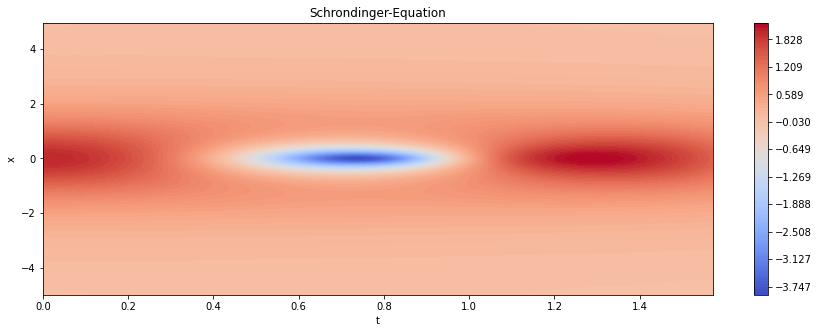

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split

# Load the .mat file
mat_data = scipy.io.loadmat('NLS.mat')

# Following is the code to plot the data u vs x and t. u is 256*100
# matrix. Use first 75 columns for training and 25 for testing :)

# Access the variables stored in the .mat file
# The variable names in the .mat file become keys in the loaded dictionary
x = mat_data['x']
t = mat_data['tt']
u = mat_data['uu']

# Use the loaded variables as needed
print(x.shape)
print(t.shape)
print(u.shape)

X, T = np.meshgrid(x, t)
# Define custom color levels
c_levels = np.linspace(np.min(u), np.max(u), 100)

# Plot the contour
plt.figure()
plt.figure(figsize=(15, 5))
plt.contourf(T, X, u.T, levels=c_levels, cmap='coolwarm')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Schrondinger-Equation')
plt.colorbar()  # Add a colorbar for the contour levels
plt.show()

In [33]:
-52 + 14

-38

In [35]:
#t[:, -3]
#t[:, -38]

In [39]:
from matplotlib.font_manager import FontProperties
plt.rcParams['axes.unicode_minus'] = False
font_path = 'times-new-roman.ttf'
custom_font = FontProperties(fname=font_path)


In [42]:
h = np.abs(u)

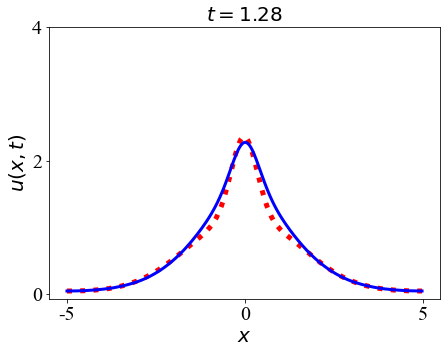

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(7, 5))  # You can adjust the width (8 inches) and height (5 inches) as needed

# Make sure the font is Times Roman
# plt.rcParams['font.family'] = 'Times New Roman'

# Perform the prediction
with torch.no_grad():
    prediction = lem(test_tensor)

final_time_output = prediction[-38, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = h[:, -38].reshape(-1, 1)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x, final_out, color='red', linestyle='dotted', linewidth=5, label='Prediction')
ax.plot(x, final_true, color='blue', linestyle='solid', linewidth=3, label='True')

# Set the axis labels
ax.set_xlabel("$x$", fontsize=20, color='black', fontproperties=custom_font)
ax.set_ylabel("$u(x, t)$", fontsize=20, color='black', fontproperties=custom_font)

# Set the title
ax.set_title("$t = 1.28$", fontsize=20, color='black', fontproperties=custom_font)

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-5, 0, 5])
ax.set_yticks([0, 2, 4])

plt.xticks(fontsize=20, fontproperties=custom_font)
plt.yticks(fontsize=20, fontproperties=custom_font)

# Set the legend
# ax.legend()

plt.savefig('1.28_sch.pdf', dpi=500)
plt.savefig('1.28_Sch.png', dpi=500)
# Show the plot
plt.show()


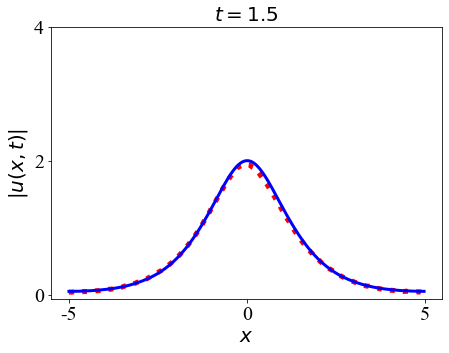

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(7, 5))  # You can adjust the width (8 inches) and height (5 inches) as needed

# Make sure the font is Times Roman
# plt.rcParams['font.family'] = 'Times New Roman'

# Perform the prediction
with torch.no_grad():
    prediction = lem(test_tensor)

final_time_output = prediction[-3, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = h[:, -3].reshape(-1, 1)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x, final_out, color='red', linestyle='dotted', linewidth=5, label='Prediction')
ax.plot(x, final_true, color='blue', linestyle='solid', linewidth=3, label='True')

# Set the axis labels
ax.set_xlabel("$x$", fontsize=20, color='black', fontproperties=custom_font)
ax.set_ylabel("$|u(x, t)|$", fontsize=20, color='black', fontproperties=custom_font)

# Set the title
ax.set_title("$t = 1.5$", fontsize=20, color='black', fontproperties=custom_font)

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-5, 0, 5])
ax.set_yticks([0, 2, 4])

plt.xticks(fontsize=20, fontproperties=custom_font)
plt.yticks(fontsize=20, fontproperties=custom_font)

# Set the legend
# ax.legend()

plt.savefig('1.5_sch.pdf', dpi=500)
plt.savefig('1.5_Sch.png', dpi=500)
# Show the plot
plt.show()


torch.Size([40, 256])
torch.Size([256])
(256, 1)
(256, 1)


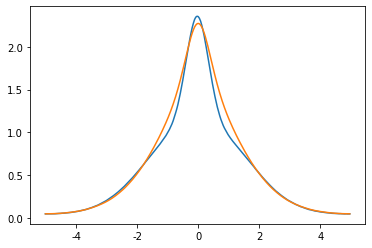

In [45]:
with torch.no_grad():
    prediction = lem(test_tensor)

print(prediction.shape)

final_time_output = prediction[-38, :]
print(final_time_output.shape)

final_out = final_time_output.detach().numpy().reshape(-1,1)
final_true = u[:,-38].reshape(-1,1)

final_true = np.abs(final_true)

print(final_out.shape)
print(final_true.shape)

x = x.reshape(-1, 1)

plt.plot(x, final_out)
plt.plot(x, final_true)
plt.show()

In [ ]:
# t = 1.2802, 1.5551

torch.Size([40, 256])
torch.Size([256])
(256, 1)
(256, 1)


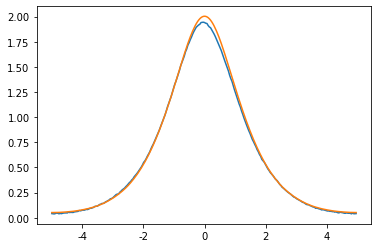

In [52]:

with torch.no_grad():
    prediction = lem(test_tensor)

print(prediction.shape)

final_time_output = prediction[-1, :]
print(final_time_output.shape)

final_out = final_time_output.detach().numpy().reshape(-1,1)
final_true = u[:,-3].reshape(-1,1)

final_true = np.abs(final_true)
#final_out = np.abs(final_out)

print(final_out.shape)
print(final_true.shape)

x = x.reshape(-1, 1)

plt.plot(x, final_out)
plt.plot(x, final_true)
plt.show()


In [53]:
# Convert NumPy arrays to PyTorch tensors
final_out_tensor = torch.from_numpy(final_out)
final_true_tensor = torch.from_numpy(final_true)
final_true_tensor = torch.abs(final_true_tensor)

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((final_out_tensor - final_true_tensor)**2)/torch.mean(final_true_tensor**2)
print("Relative Error Test: ", relative_error_test.item(), "")

Relative Error Test:  0.0008894816132805881 
